### Imports

In [226]:
# Stanadard libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Machine Learning Skripts 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.inspection import permutation_importance


# Functions from other scripts
from DataCollectionScript import load_SQL_Data

### Preparing Data For Machine Learning

In [227]:
df = load_SQL_Data()

# preprocessing data
def remove_null(df):
    """ Removes null values by dropping the rows they are in and drops unneeded rows"""
    #print(f"Columns & rows before cleaning: {df.shape}")
    # Drop all rows that have null values
    df = df.dropna()

    #Dropping unneeded columns 
    drop_list = ['uuid','matchId','participants','puuid','endOfGameResult','gameId','patch','riotIdGameName','riotIdTagline','summonerName','lane','role']
    df = df.drop(drop_list, axis=1)

    #print(f'Columns & rows after cleaning: {df.shape}')

    return df

# splitting features 
def split_features(df):
    """ Splits features into X and Y variables """

    # selecting filtered data
    df = remove_null(df)

    # Splitting features into x and y
    x = df.drop(['win'], axis=1)
    y = df['win']

    # define numerical and categorical featues
    num_cols = x.select_dtypes(include='number').columns
    cat_cols = x.select_dtypes(include='object').columns
    # create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)   
    return X_train, X_test, y_train, y_test, num_cols, cat_cols


### Building Gradient Boosting Model

In [228]:
def build_gb_preprocessor(num_cols, cat_cols):
    ''' Standard Preprocessor'''
    gb_preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ]
    )
    return gb_preprocessor



# build the Gradient boosting model
def build_gb_model(num_cols, cat_cols):

    """ Builds gradient boosting pipeline needs numerical and categorical columns, returns pipeline"""
    
    # gets preprocessor
    gb_preprocessor = build_gb_preprocessor(num_cols,cat_cols)
    
    gb_pipeline = Pipeline([
        ('preprocessor', gb_preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])

    return gb_pipeline

# Run the Gradient boosting model
def run_gb_model(df):

    """ Runs the fulls GB model, returns: fitted model, y pred and y test """
    # Get the split features and column names
    X_train, X_test, y_train, y_test, num_cols, cat_cols = split_features(df)
    
    # Build and train the GradientBoosting model
    gb_model = build_gb_model(num_cols, cat_cols)
    fitted_model = gb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = fitted_model.predict(X_test)

    return fitted_model, y_pred, y_test # can use _, to ignore values you don't want

def save_model(df):
    # Get model, predictions (y_pred), and true values (y_test)
    model, y_pred, y_test = run_gb_model(df)
    
    # Save the model
    with open("model.pkl", "wb") as model_file:
        pickle.dump(model, model_file)
    
    # Save the predictions and true values
    with open("y_pred_y_test.pkl", "wb") as pred_file:
        pickle.dump((y_pred, y_test), pred_file)
    
    print("Model has been saved!")

def load_model():
    # Load the model
    with open("model.pkl", "rb") as model_file:
        loaded_model = pickle.load(model_file)
    
    # Load the predictions and true values
    with open("y_pred_y_test.pkl", "rb") as pred_file:
        y_pred, y_test = pickle.load(pred_file)
    
    return loaded_model, y_pred, y_test

### Defining Accuracy Functions

Accuracy with Gradient Boosting: 0.9758211678832117

Classification Report:
               precision    recall  f1-score   support

    Loss (0)       0.96      0.98      0.97       896
     Win (1)       0.99      0.97      0.98      1296

    accuracy                           0.98      2192
   macro avg       0.97      0.98      0.98      2192
weighted avg       0.98      0.98      0.98      2192



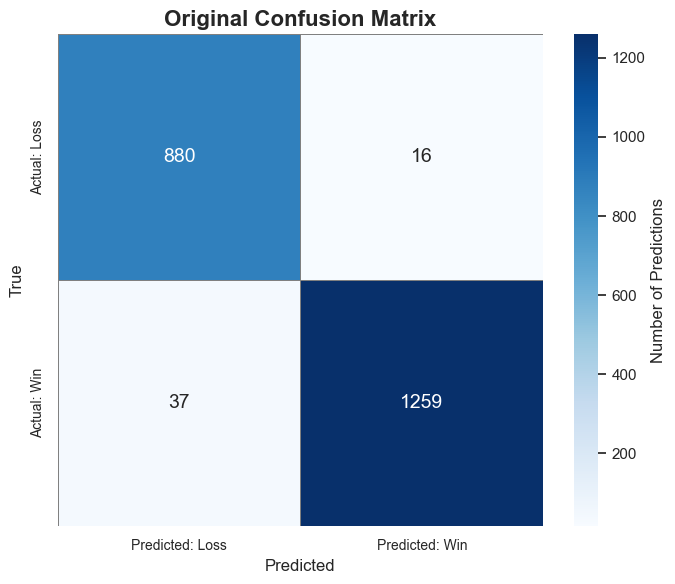

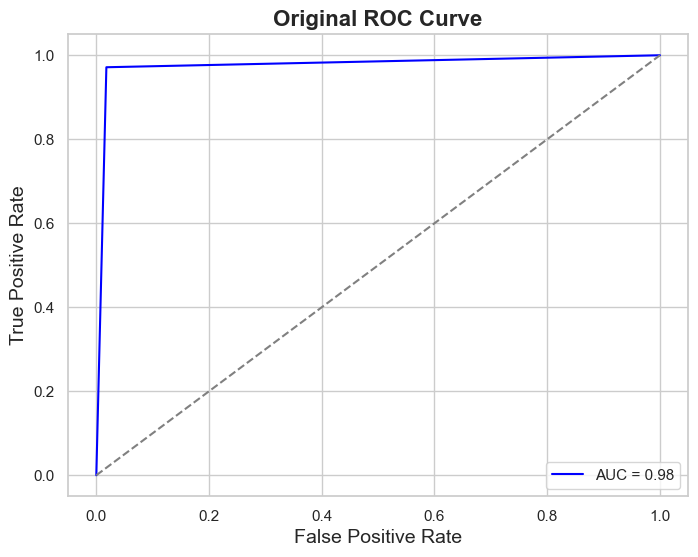

In [229]:
model, y_pred, y_test =  load_model()

def show_accuracy(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy with Gradient Boosting:", accuracy)

def create_confusion_matrix(y_test,y_pred,name):
    
    # Generate confusion matrix using sklearn's confusion_matrix
    cm = sk_confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(7, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted: Loss', 'Predicted: Win'],
                yticklabels=['Actual: Loss', 'Actual: Win'],
                cbar_kws={'label': 'Number of Predictions'},
                annot_kws={"size": 14}, linewidths=0.5, linecolor='gray')

    plt.title(f'{name} Confusion Matrix', fontsize=16, weight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()


def class_report(y_test,y_pred):
    report = classification_report(y_test, y_pred, target_names=['Loss (0)', 'Win (1)'])
    print("Classification Report:\n", report)

def create_roc(y_test,y_pred,name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # y_pred_prob is the probability of the positive class
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'{name} ROC Curve', fontsize=16, weight = 'bold')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def full_report(y_test,y_pred, name):
    """ Gives a full report of the machine learning model"""
    show_accuracy(y_test,y_pred)
    print()
    class_report(y_test,y_pred)
    create_confusion_matrix(y_test,y_pred,name)
    create_roc(y_test,y_pred,name)

full_report(y_test,y_pred, 'Original')

### Testing Hypothesis Groups

Items Only Group Results 

Accuracy with Gradient Boosting: 0.5880474452554745

Classification Report:
               precision    recall  f1-score   support

    Loss (0)       0.49      0.18      0.27       896
     Win (1)       0.61      0.87      0.71      1296

    accuracy                           0.59      2192
   macro avg       0.55      0.53      0.49      2192
weighted avg       0.56      0.59      0.53      2192



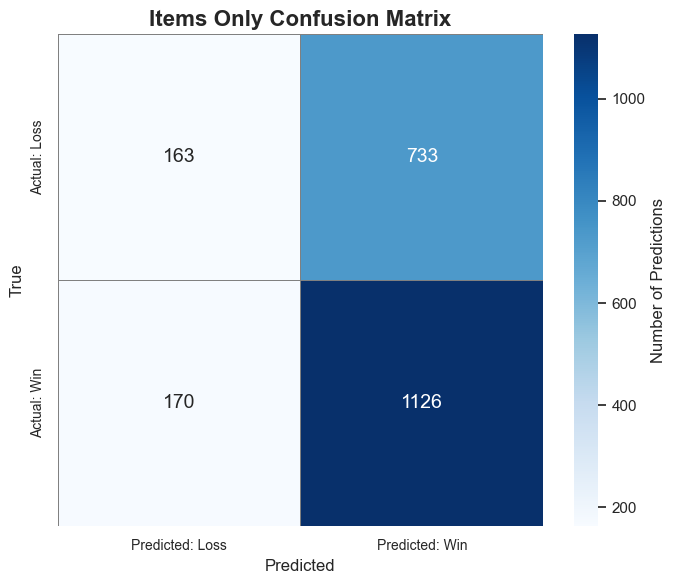

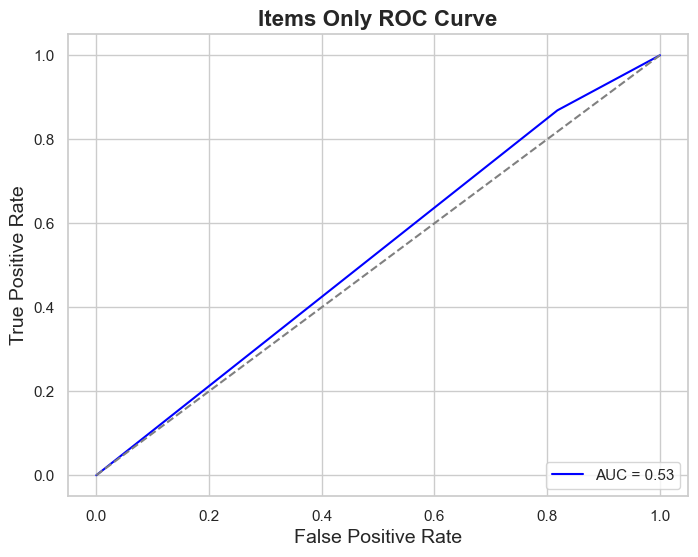

Champions Only Group Results 

Accuracy with Gradient Boosting: 0.5784671532846716

Classification Report:
               precision    recall  f1-score   support

    Loss (0)       0.37      0.04      0.08       896
     Win (1)       0.59      0.95      0.73      1296

    accuracy                           0.58      2192
   macro avg       0.48      0.50      0.40      2192
weighted avg       0.50      0.58      0.46      2192



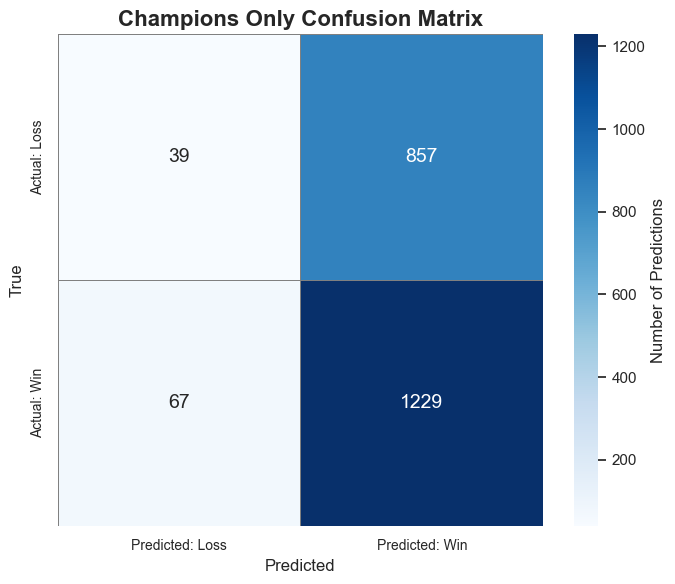

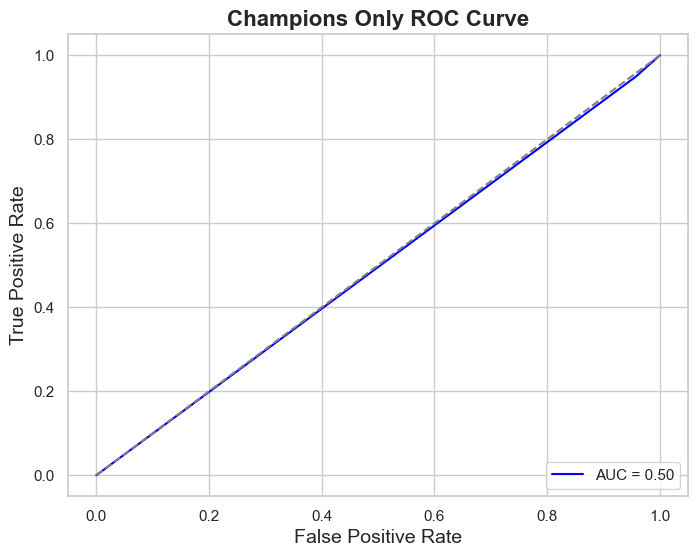

20 Most Important Features Group Results 

Accuracy with Gradient Boosting: 0.9744525547445255

Classification Report:
               precision    recall  f1-score   support

    Loss (0)       0.96      0.98      0.97       896
     Win (1)       0.98      0.97      0.98      1296

    accuracy                           0.97      2192
   macro avg       0.97      0.97      0.97      2192
weighted avg       0.97      0.97      0.97      2192



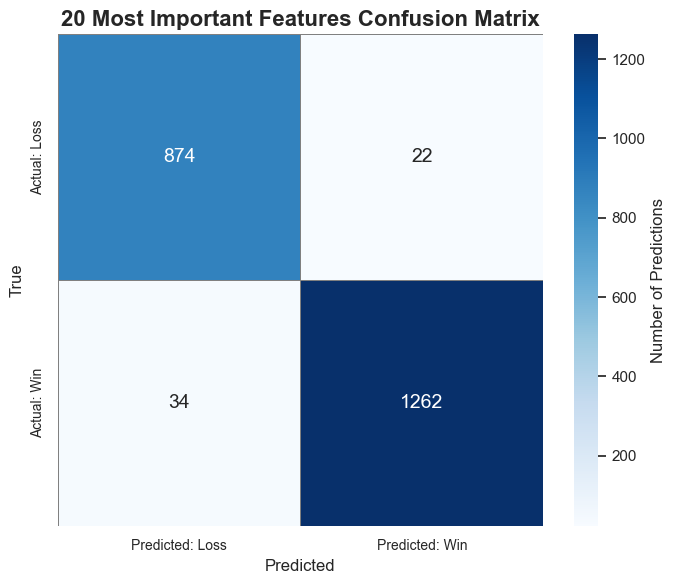

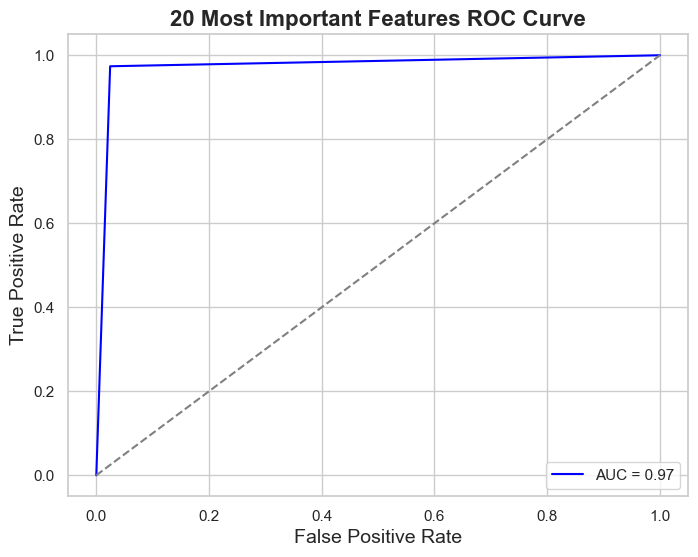

In [230]:
def alternate_model_info(columns_of_interest):
    df = load_SQL_Data()

    required_list = ['uuid','matchId','participants','puuid','endOfGameResult','gameId','patch','riotIdGameName','riotIdTagline','summonerName','lane','role','win']
    columns_keep = columns_of_interest[1:] + required_list 
    df = df[columns_keep]

    _, y_pred, y_test = run_gb_model(df)

    full_report(y_test,y_pred, columns_of_interest[0])


# creating groups of interest 
# The first item in the list will be the name of the group for naming the graphs

items_only = ['Items Only','item0',
'item1',
'item2',
'item3',
'item4',
'item5',
'itemsPurchased']

champions_only = ['Champions Only','blue_champ1',
'blue_champ2',
'blue_champ3',
'blue_champ4',
'blue_champ5',
'red_champ1',
'red_champ2',
'red_champ3',
'red_champ4',
'red_champ5','championName']

top20_signifigance = ['20 Most Important Features',
'turretsLost',
'teamKills',
'inhibitorsLost',
'inhibitorTakedowns',
'turretTakedowns',
'dragon_kills',
'baron_kills',
'deaths',
'perctTimeDead',
'itemsPurchased',
'cs',
'atakhan_killed',
'champExperience',
'voidGrubs_kills',
'damageDealtToTurrets',
'totalHeal',
'totalDamageDealt']


groups = [items_only, champions_only, top20_signifigance]

for group in groups:
    print(f"{group[0]} Group Results \n")
    alternate_model_info(group)

### Displaying Most Important Features

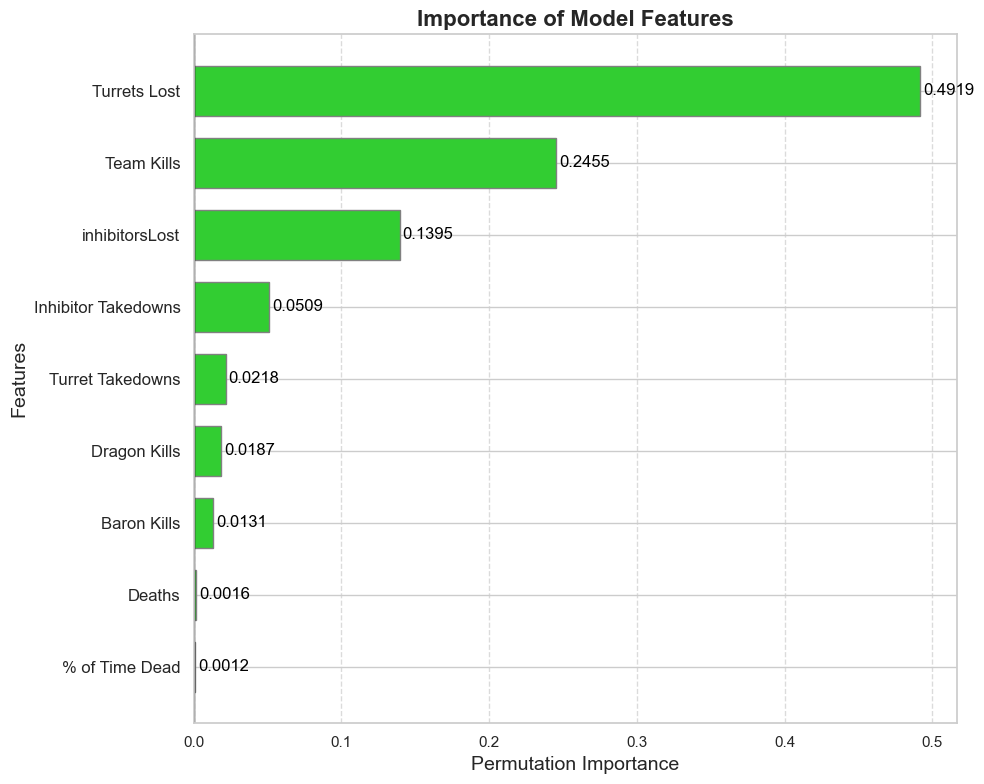

In [231]:
def get_feature_importance(model, X_train, num_cols, cat_cols):
    # Access the trained model from the pipeline
    gb_classifier = model.named_steps['classifier']  # Access GradientBoostingClassifier part of the pipeline
    
    # Get feature importance from the trained GradientBoostingClassifier
    importance = gb_classifier.feature_importances_

    # Get the transformed feature names from the ColumnTransformer
    # Apply one hot encoding to the categorical columns
    preprocessor = model.named_steps['preprocessor']  # Access ColumnTransformer part of the pipeline
    X_transformed = preprocessor.transform(X_train)
    
    # Get feature names after transformation
    # For numerical features, they remain the same
    feature_names = num_cols.tolist()  # Numerical features
    cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)  # OneHotEncoded categorical features
    
    # Combine both to get the full list of feature names after transformation
    all_feature_names = feature_names + list(cat_feature_names)

    # Filter out features with Little importance
    non_zero_importance_idx = importance > 0.001

    # creates index num for each filtered out item
    non_zero_importance_idx = np.where(non_zero_importance_idx == True)[0]
    # gets the value for each index
    filtered_importance = importance[non_zero_importance_idx]
    filtered_feature_names = np.array(feature_names)[non_zero_importance_idx]



    # Create a DataFrame for the feature importance and feature names
    feature_importance_df = pd.DataFrame({'Features': filtered_feature_names, 'Importance': filtered_importance})

    # Sort the features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
    
    return feature_importance_df


model, y_pred, y_test = load_model()  # Get the loaded model

# Get the original training data and the numerical and categorical columns
X_train, X_test, y_train, y_test, num_cols, cat_cols = split_features(df)  # Get the split data for feature names

# Get feature importance as DataFrame
feature_importance_df = get_feature_importance(model, X_train, num_cols, cat_cols)

#save the file to csv
#feature_importance_df.to_csv('feature_importance.csv',index=False)


def create_feature_importance_graph(df, model, custom_labels = None):
    """ 
    Creates vertical bar graph of the top 0.001 most important values

    custom_labels info: 
    you to add custome graph y tick names
    you can create a list of names in order from top to bottom and it will match up
    if the number of names is wrong len this will not work
    

    """    

    # get split features
    X_train, _, _, _, num_cols, cat_cols = split_features(df)

    # calculate the feature importance
    feature_importance_df = get_feature_importance(model, X_train, num_cols, cat_cols)


    importance = feature_importance_df['Importance']
    feature_names = feature_importance_df['Features']


    # Set seaborn style for better visuals
    sns.set(style="whitegrid")

    # Plotting the permutation importance
    plt.figure(figsize=(10, 8))

    # Bar chart with improved aesthetics
    bars = plt.barh(range(len(importance)), importance, color='limegreen', edgecolor='grey', height=0.7)

    # Use custom labels or feature names for y-ticks
    if custom_labels is not None:
        
        # Make list backwards
        custom_labels.reverse()

        plt.yticks(range(len(importance)), custom_labels, fontsize=12)
    else:
        plt.yticks(range(len(importance)), feature_names, fontsize=12)

    # Set x and y labels with larger font size
    plt.xlabel("Permutation Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)

    # Set the title with a larger font size and bold style
    plt.title("Importance of Model Features", fontsize=16, weight='bold')

    # Add a grid for better readability of values
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Optional: Add a horizontal line at y=0 for clarity
    plt.axvline(x=0, color='black', linewidth=1)

    # Add the importance score at the end of each bar
    for i, bar in enumerate(bars):
        importance_score = importance.iloc[i]  # This should align with the feature name at the same index
        plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2, f'{importance_score:.4f}', 
                 va='center', ha='left', fontsize=12, color='black')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Important findings

""" 

Items had very little impact
Runes had little impact
champions had little impact (only  a few were listed as impactful)
summoner spells had no impact

Objectives had a small impact
deaths had a small impact 

inhibitor & turret take downs were important 

turrets lost was the most important

Team kills was the second most important



"""

graph_labels = ['Turrets Lost','Team Kills','inhibitorsLost','Inhibitor Takedowns', 'Turret Takedowns','Dragon Kills','Baron Kills','Deaths','% of Time Dead']

create_feature_importance_graph(df,model,graph_labels)


### Showing Impact of Importance

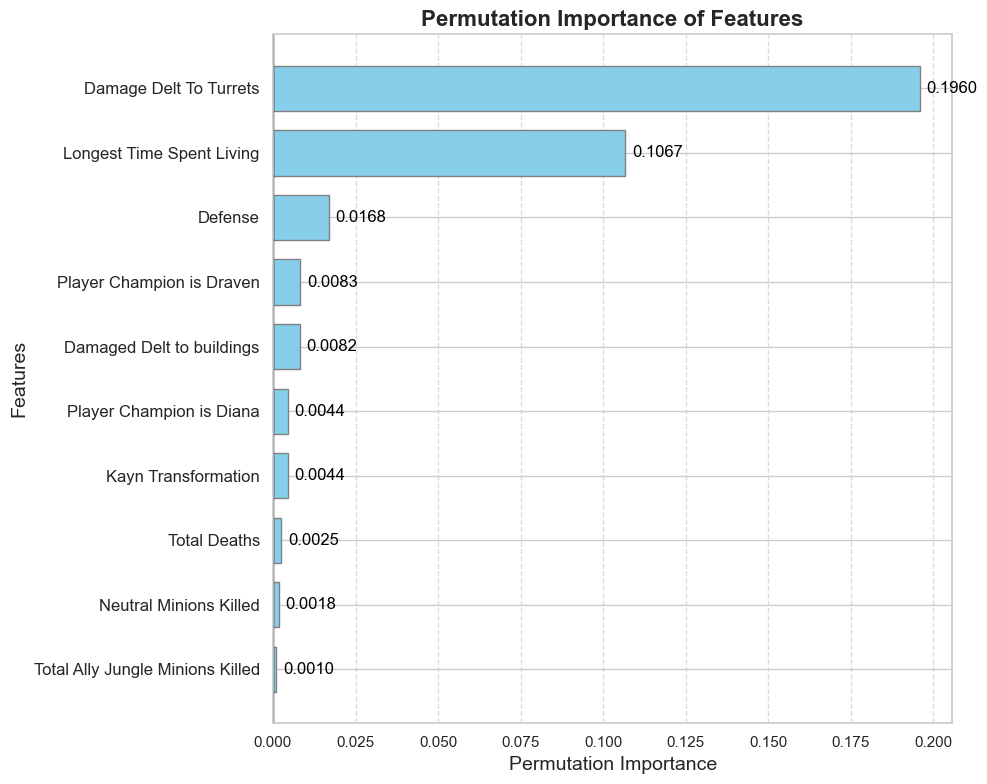

In [232]:
# Load model 
model, y_pred, y_test = load_model()

def calc_permutation_importance(df, model):
    # load preprocessor
    preprocessor = model.named_steps['preprocessor']

    # Load X and Y dataframes
    X_train, _, y_train, _, num_cols, cat_cols = split_features(df)

    # 2. Perform permutation importance (ensure that X_train is processed through the pipeline first)
    result = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=42, n_jobs=-1) # this function takes a while to run, with all cores takes 20.8 seconds (better than 2 minutes)

    # getting Importance Scores
    importance = result.importances_mean

    # getting encoded categorical columns
    preprocessor = model.named_steps['preprocessor']
    encoded_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)
    # saving feature names and numerical columns
    feature_names = num_cols.to_list() + list(encoded_feature_names)

    # Check that the number of features matches
    #print(f"Number of features after transformation: {len(feature_names)}")
    #print(f"Number of importance values: {len(importance)}")
    # debugging code ^

    # Filter out features with zero importance
    non_zero_importance_idx = importance > 0.001

    # creates index num for each filtered out item
    non_zero_importance_idx = np.where(non_zero_importance_idx == True)[0]
    # gets the value for each index
    filtered_importance = importance[non_zero_importance_idx]
    filtered_feature_names = np.array(feature_names)[non_zero_importance_idx].tolist()

    permutation_importance_df = pd.DataFrame({
        'Features' : filtered_feature_names, 
        'Importance' : filtered_importance
    })


    permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=True)

    return permutation_importance_df

def create_permutation_importance_graph(df, model, custom_labels = None):
    """ 
    Creates vertical bar graph of the top 0.001 most important values

    custom_labels info: 
    you to add custome graph y tick names
    you can create a list of names in order from top to bottom and it will match up
    if the number of names is wrong len this will not work
    

    """    
    permutation_importance_df = calc_permutation_importance(df, model)


    importance = permutation_importance_df['Importance']
    feature_names = permutation_importance_df['Features']


    # Set seaborn style for better visuals
    sns.set(style="whitegrid")

    # Plotting the permutation importance
    plt.figure(figsize=(10, 8))

    # Bar chart with improved aesthetics
    bars = plt.barh(range(len(importance)), importance, color='skyblue', edgecolor='grey', height=0.7)

    # Use custom labels or feature names for y-ticks
    if custom_labels is not None:
        
        # Make list backwards
        custom_labels.reverse()

        plt.yticks(range(len(importance)), custom_labels, fontsize=12)
    else:
        plt.yticks(range(len(importance)), feature_names, fontsize=12)

    # Set x and y labels with larger font size
    plt.xlabel("Permutation Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)

    # Set the title with a larger font size and bold style
    plt.title("Permutation Importance of Features", fontsize=16, weight='bold')

    # Add a grid for better readability of values
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Optional: Add a horizontal line at y=0 for clarity
    plt.axvline(x=0, color='black', linewidth=1)

    # Add the importance score at the end of each bar
    for i, bar in enumerate(bars):
        importance_score = importance.iloc[i]  # This should align with the feature name at the same index
        plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2, f'{importance_score:.4f}', 
                 va='center', ha='left', fontsize=12, color='black')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

graph_labels = ['Damage Delt To Turrets','Longest Time Spent Living','Defense','Player Champion is Draven','Damaged Delt to buildings',
'Player Champion is Diana','Kayn Transformation','Total Deaths','Neutral Minions Killed','Total Ally Jungle Minions Killed']

# damage dealt to buildings is nexus damage

create_permutation_importance_graph(df,model, custom_labels= graph_labels)